# Topic analysis based on Genius songs lyrics

Author : lievre.thomas@gmail.com

---

In this notebook, we will explore the genius data extract from [Kaggle](https://www.kaggle.com/datasets/carlosgdcj/genius-song-lyrics-with-language-information).

The first aim of this analysis is to retrieve topic from lyrics and retrieve main topics by year or decade.


## Load the data in memory

Data are all contain in a big 9GB csv file (around 5 millions rows). It could be dificult to load all this data in our computer memory. To deal with this issue, I made a loading class to split the data in 6 pickles files to improve the compressness of the data which aim to improve the loading speed in the memory. Then the pickles are randomly draw to improve generality of the data. I assumed the data pickles batch are identically distributed (we will show it at the end of this part). The class below deal with all the process.

In [5]:
import pandas as pd
from random import seed, sample
import pickle
import glob
import os

class Loader():

    def __init__(self, in_path, out_path):
        """
        Args:
            in_path (str): csv input path.
            out_path (str): Output directory path to store the pickles.
            chunksize (int, optional): Chunksize for DataFrame reader. Defaults to 10**6. 
        """

        self.__in_path = in_path
        self.__out_path = out_path
        self.__chunksize = 10**6

    def __produce_pickles(self):
        """produce pickles by reading csv by chunksize
        """
        with pd.read_csv(self.__in_path, chunksize = self.__chunksize) as reader:
            try:
                os.makedirs(self.__out_path)
            except FileExistsError:
                # directory already exists
                pass
            for i, chunk in enumerate(reader):
                out_file = self.__out_path + "/data_{}.pkl".format(i+1)
                with open(out_file, "wb") as f:
                    pickle.dump(chunk, f, pickle.HIGHEST_PROTOCOL)
    
    def load_pickle(self, pickle_id):
        """load a pickle file by id

        Args:
            pickle_id (int): pickle id.

        Raises:
            Exception: The path of the given id isn't a file

        Returns:
            obj: DataFrame
        """
        # produce the pickles if the directory not exists or
        # if the directory is empty 
        if (not os.path.exists(self.__out_path)) or \
              (len(os.listdir(self.__out_path)) == 0):
            self.__produce_pickles()
        
        # get the file path following the pickle_id
        # given in parameter
        file_path = self.__out_path + \
            "/data_" + pickle_id + ".pkl"

        if os.path.isfile(file_path):
            df = pd.read_pickle(file_path)
        else:
            raise Exception("The pickle file data_{}.pkl doesn't exist".format(pickle_id))
        return df
        

    def random_pickles(self, n_pickles = 3, init = 42, verbose = True):
        """random reader over pickles files

        Args:
            n_pickles (int, optional): number of pickles to load. Defaults to 3.
            init (int, optional): Integer given to the random seed. Defaults to 42.
            verbose (bool, optional): Print the loaded files. Defaults to True

        Raises:
            Exception: Stop the process if n_pickles exceed pickle files number.

        Returns:
            obj: pd.Dataframe
        """

        # produce the pickles if the directory not exists or
        # if the directory is empty 
        if (not os.path.exists(self.__out_path)) or \
              (len(os.listdir(self.__out_path)) == 0):
            self.__produce_pickles()

        pickle_files = [name for name in
                        glob.glob(self.__out_path + "/data_*.pkl")]
        # draw p_files        
        seed(init)

        if n_pickles <= 6:
            random_p_files = sample(pickle_files, n_pickles)
        else:
            raise Exception("The parameter n_pickles (" +
                            "{}) exceed the numbers of pickle files ({})"\
                                .format(n_pickles, len(pickle_files)))
        # print the drawed files
        if verbose:
            print("Loaded pickles:")
            for p in random_p_files:
                print(p)

        # load random pickles file
        df_list = [pd.read_pickle(p) for p in random_p_files]

        # create the dataframe by concatenate the previous
        # dataframes list
        df = pd.concat(df_list, ignore_index = True)
        return df

In [9]:
# create reader
loader = Loader(in_path = "./song_lyrics.csv", out_path = "data/")

df = loader.random_pickles(n_pickles = 2, init = 1)

Loaded pickles :
data/data_3.pkl
data/data_6.pkl


Because we can't load all the data in memory, we choose to only the 3 first batch of data. I don't really know now how the data are indexed and if distribution of data over year are quite similar.

In [10]:
df.head()

title   tag        artist  year  views               features  \
0           Roses  rock         Vitja  2017    399                     {}   
1  Keep On Pushin   rap       Problem  2017    692  {"My Princess Aeryn"}   
2          Inside   pop  The jepettos  2017   1302                     {}   
3  Girls Like You    rb      PnB Rock  2017  60114                     {}   
4        Froideur   rap   N'Dirty Deh  2017   5813      {"N\\'Dirty Deh"}   

                                              lyrics       id language_cld3  \
0  The roses start to wither\nWhere the devil lay...  3019113            en   
1  [Hook]\nImma keep on pushin\nImma keep on push...  3019114            en   
2  [Intro]\nOoh, ooh, ah, ah (x2)\n\n[Verse 1]\nI...  3019115            en   
3  [Chorus]\nBaby it was real\nYeah we were the b...  3019117            en   
4  [Refrain]\nEt j'ai perdu la foi, mais c'est pa...  3019120            fr   

  language_ft language  
0          en       en  
1          en       en  
2          en       en  
3          en       en  
4          fr       fr

In [11]:
df.dtypes

title            object
tag              object
artist           object
year              int64
views             int64
features         object
lyrics           object
id                int64
language_cld3    object
language_ft      object
language         object
dtype: object

In [12]:
# print the size
df.size

12483416

## Preprocess the data

**year** columns values sometimes get some little format issues (example : 05 instead of 2005 or 97 instead of 1979) 

In [3]:
import plotly.express as px

df_year = df.groupby(['year'])['year'].count()

df.drop(df[df.year == 2027].index, inplace=True)

def filter_wrong_format(x):
    if x > 100 and x <= 2023:
        fyear = x
    else:
        if x >= 0 and x <= 23:
            fyear = x + 2000
        elif x >= 23 and x < 100:
            fyear = x + 1900
        else:
            raise Exception(
                "Something seems wrong with filters value : {}"
                .format(x))
    return fyear # return the fixed year

assert filter_wrong_format(2000) == 2000
assert filter_wrong_format(9) == 2009
assert filter_wrong_format(71) == 1971



In [4]:
# replace the column name
df['year'] = df['year'].apply(filter_wrong_format)
df['year'].unique()
len(df)

1000000

As we can see below on the barplot over year, we've got a very large amount of data for the last decade. I'm pretty sure that the distribution is quite similar for the next 3 samples. 

In [5]:
import plotly.express as px
df_year2 = df.groupby(['year']).size().reset_index(name='count')

fig = px.bar(df_year2.loc[df_year2['year'] > 1960], x="year", y="count")
fig.show()


## 2015 songs lyrics topic modelling

Let's first retrieve the english song in 2015 (year of with max genius lyrics repertoried).

In [6]:
df_2015_en = df[(df['year'] == 2015) & (df['language'] == 'en')]
df_2015_en.head()

title  tag               artist  \
19                                 Dont Cry My Love  pop            Vera Lynn   
39  Dont Think About Her When Youre Trying To Drive  pop           John Hiatt   
41                                            Crazy  pop     Chantal Chamandy   
50                                        Marcs Car  pop         Swizzle Tree   
54                                  Song for No One  pop  The Lightning Seeds   

    year  views features                                             lyrics  \
19  2015    748       {}  A soldier boy, so brave and gay\nWith head hel...   
39  2015    411       {}  She don't know who you're missin'\nDrivin' dow...   
41  2015     53       {}  There are so many ways to say je t'aime\nBut o...   
50  2015    105       {}  I remember when we used to ride\nIn the back o...   
54  2015    432       {}  From night skies dressed in cloud\nMorning cam...   

         id language_cld3 language_ft language  
19  1325221            en          en       en  
39  1325242            en          en       en  
41  1325244            en          en       en  
50  1325253            en          en       en  
54  1325257            en          en       en

Let's plot the tag distribution

In [7]:
df_tag = df_2015_en.groupby(['tag']).size().reset_index(name='count')

fig = px.bar(df_tag, x="tag", y="count", color='tag')
fig.show()

The barplot below shows the frequency of each tag color by total views

In [8]:
# retrieve groups
total_tag_views = df_2015_en.groupby(['tag'])['views'].sum()
tag_freq = df_2015_en.groupby(['tag']).size()

# create df
df_tag = pd.DataFrame({'count' : tag_freq,'total_views' :total_tag_views})
df_tag.reset_index(inplace = True, names = 'tag')

# print the barplot
fig = px.bar(df_tag, x="tag", y="count", color='total_views')
fig.show()

Let's try topic modelling with top2vec library which is the easiest to start. But first let's filter the lyrics.

In [9]:
text = df_2015_en.lyrics.iloc[0]
text

"A soldier boy, so brave and gay\nWith head held high, he marched away\nHis sweetheart wept, but every night\nHe'd think of her and he would write\nDon't cry, my love, while I am gone\nDon't sigh, my love, just carry on\n\nThe leaves of green turned brown and gold\nThe days grew short and nights were cold\nBut when the winter winds blew chill\nAfire with love, he'd write her still\nDon't cry, my love, while I am gone\nDon't sigh, my love, just carry on\n\nThen came the day he'd hungered for\nWhen he need live on dreams no more\nFor he could write and it was true\nMy dear, I'll soon be home to you\nDon't cry, my love, I'm coming home\nDon't sigh, my love, no more I'll roam\nWe two again will never part\nStand easy, love, you've won my heart"

In [10]:
text = text.replace('\n', '')
text

"A soldier boy, so brave and gayWith head held high, he marched awayHis sweetheart wept, but every nightHe'd think of her and he would writeDon't cry, my love, while I am goneDon't sigh, my love, just carry onThe leaves of green turned brown and goldThe days grew short and nights were coldBut when the winter winds blew chillAfire with love, he'd write her stillDon't cry, my love, while I am goneDon't sigh, my love, just carry onThen came the day he'd hungered forWhen he need live on dreams no moreFor he could write and it was trueMy dear, I'll soon be home to youDon't cry, my love, I'm coming homeDon't sigh, my love, no more I'll roamWe two again will never partStand easy, love, you've won my heart"

In [11]:
import re
text = re.sub('[,\.!?]', '', text)
text

"A soldier boy so brave and gayWith head held high he marched awayHis sweetheart wept but every nightHe'd think of her and he would writeDon't cry my love while I am goneDon't sigh my love just carry onThe leaves of green turned brown and goldThe days grew short and nights were coldBut when the winter winds blew chillAfire with love he'd write her stillDon't cry my love while I am goneDon't sigh my love just carry onThen came the day he'd hungered forWhen he need live on dreams no moreFor he could write and it was trueMy dear I'll soon be home to youDon't cry my love I'm coming homeDon't sigh my love no more I'll roamWe two again will never partStand easy love you've won my heart"

In [12]:
text = text.lower()
text

"a soldier boy so brave and gaywith head held high he marched awayhis sweetheart wept but every nighthe'd think of her and he would writedon't cry my love while i am gonedon't sigh my love just carry onthe leaves of green turned brown and goldthe days grew short and nights were coldbut when the winter winds blew chillafire with love he'd write her stilldon't cry my love while i am gonedon't sigh my love just carry onthen came the day he'd hungered forwhen he need live on dreams no morefor he could write and it was truemy dear i'll soon be home to youdon't cry my love i'm coming homedon't sigh my love no more i'll roamwe two again will never partstand easy love you've won my heart"

In [44]:
def clean_text(text):
    # remove \n
    text = text.replace('\n', '')
    # remove punctuation
    text = re.sub('[,\.!?]', '', text)
    #removing text in square braquet
    text = re.sub('\[.*?\]', ' ', text)
    #removing figures
    text = re.sub('\w*\d\w*',' ', text)
    # convert all words in lower case
    text = text.lower()
    return text

results = df_2015_en["lyrics"].apply(clean_text)

docs = results.to_list()
docs[:2]

["a soldier boy so brave and gaywith head held high he marched awayhis sweetheart wept but every nighthe'd think of her and he would writedon't cry my love while i am gonedon't sigh my love just carry onthe leaves of green turned brown and goldthe days grew short and nights were coldbut when the winter winds blew chillafire with love he'd write her stilldon't cry my love while i am gonedon't sigh my love just carry onthen came the day he'd hungered forwhen he need live on dreams no morefor he could write and it was truemy dear i'll soon be home to youdon't cry my love i'm coming homedon't sigh my love no more i'll roamwe two again will never partstand easy love you've won my heart",
 "she don't know who you're missin'drivin' down that lonesome road tonightlooking for one starlight glowingor her face shining in the dashlightdriving out of natchezyou drive her back and forth across your mindtires squeal as the wheels spin fasterlove's gone for good this timedon't think about hermove on y

In [14]:
import multiprocessing
multiprocessing.cpu_count()

8

In [15]:
from top2vec import Top2Vec

model = Top2Vec(docs, speed = 'fast-learn', workers = multiprocessing.cpu_count())

2023-03-07 17:00:56,442 - top2vec - INFO - Pre-processing documents for training
2023-03-07 17:02:13,090 - top2vec - INFO - Creating joint document/word embedding
2023-03-07 17:53:25,411 - top2vec - INFO - Creating lower dimension embedding of documents
2023-03-07 17:55:43,174 - top2vec - INFO - Finding dense areas of documents
2023-03-07 17:56:01,399 - top2vec - INFO - Finding topics


In [17]:
import os
from datetime import datetime

try:
    os.makedirs('models')
except:
    pass

today = datetime.now().strftime("%d%m%Y")

path = "models/" + "top2vec_" + today

model.save(path)
model = Top2Vec.load(path)

In [18]:
model.get_num_topics()

457

In [24]:
topic_sizes, topic_nums = model.get_topic_sizes()
topic_sizes

array([11991,  6474,  5398,  4503,  4124,  3960,  3915,  3775,  3580,
        3161,  3113,  2989,  2754,  2714,  2516,  2413,  2367,  2317,
        2287,  2256,  2150,  1875,  1801,  1623,  1594,  1567,  1418,
        1369,  1342,  1307,  1253,  1235,  1178,  1171,  1159,  1137,
        1125,  1119,  1062,  1042,   997,   991,   976,   975,   915,
         857,   848,   838,   782,   769,   700,   683,   674,   664,
         660,   653,   652,   648,   642,   629,   623,   616,   614,
         614,   614,   584,   565,   558,   545,   538,   538,   526,
         525,   524,   524,   520,   519,   519,   505,   505,   502,
         502,   495,   494,   491,   482,   475,   468,   467,   465,
         457,   445,   433,   421,   420,   408,   399,   391,   391,
         387,   371,   362,   359,   356,   355,   354,   353,   328,
         322,   321,   318,   317,   314,   307,   293,   289,   288,
         288,   270,   270,   269,   263,   263,   262,   261,   254,
         245,   244,

In [27]:
topic_words, word_scores, topic_nums = model.get_topics(457)
topic_words[0]

array(['these', 'nigga', 'niggas', 'ain', 'fuck', 'shit', 'got', 'pull',
       'bitch', 'feds', 'swear', 'lil', 'they', 'them', 'couple', 'tryna',
       'clip', 'block', 'niggai', 'some', 'like', 'bands', 'hook', 'hoes',
       'glock', 'my', 'real', 'bitches', 'with', 'dope', 'chopper', 'on',
       'hit', 'verse', 'broke', 'rich', 'money', 'still', 'gon', 'hood',
       'whole', 'shiti', 'pussy', 'shooters', 'crib', 'wit', 'just',
       'know', 'beef', 'up'], dtype='<U15')

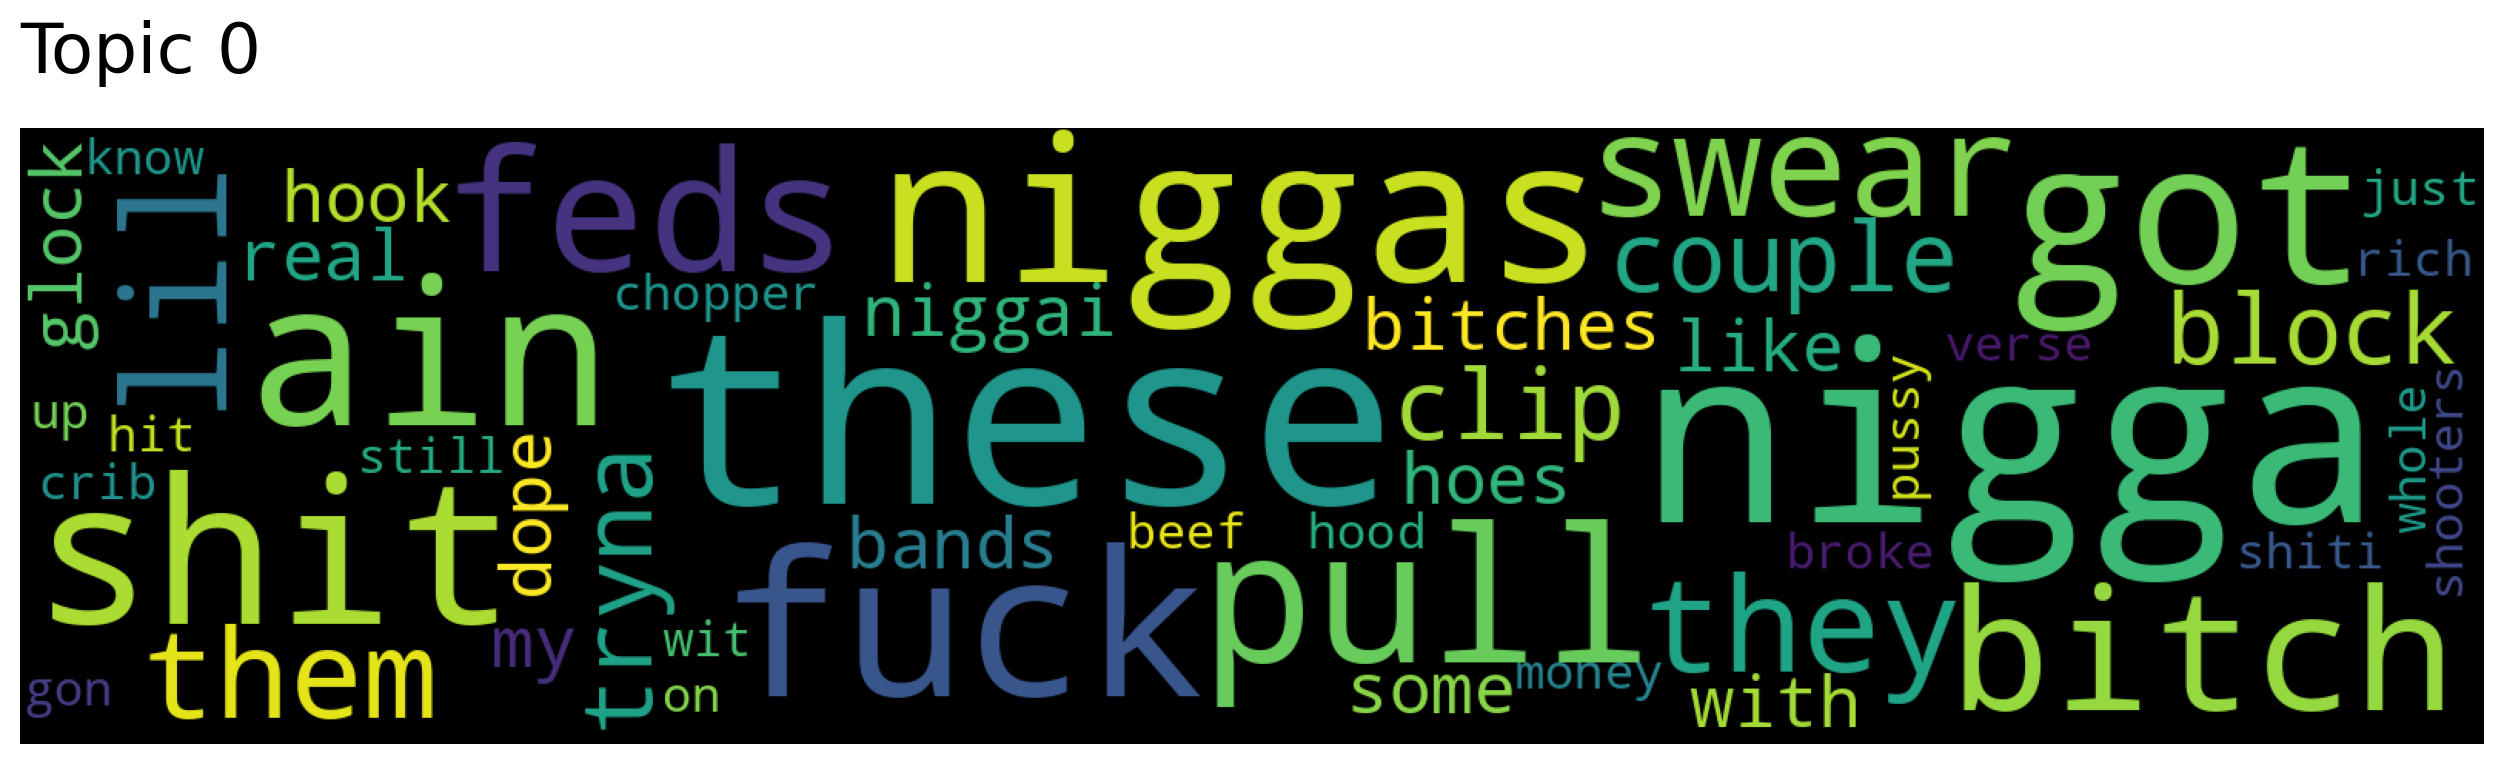

In [28]:
model.generate_topic_wordcloud(topic_nums[0])

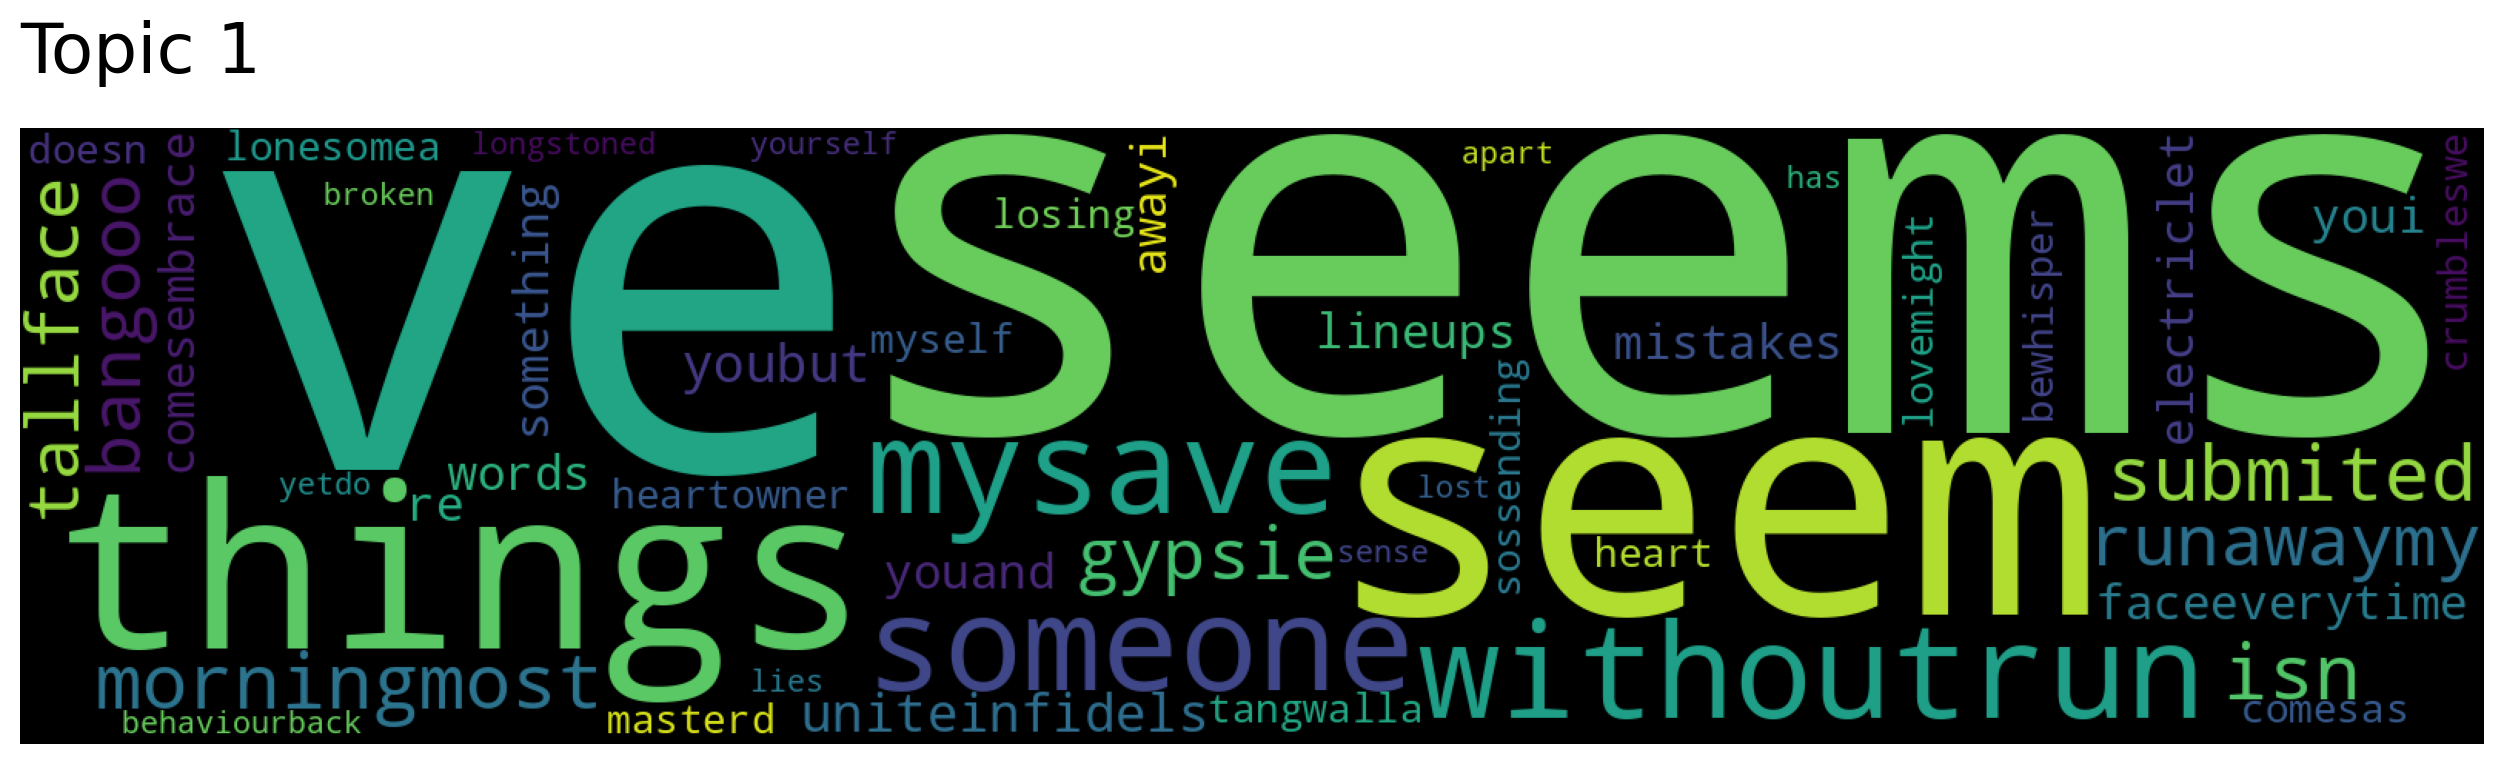

In [29]:
model.generate_topic_wordcloud(topic_nums[1])

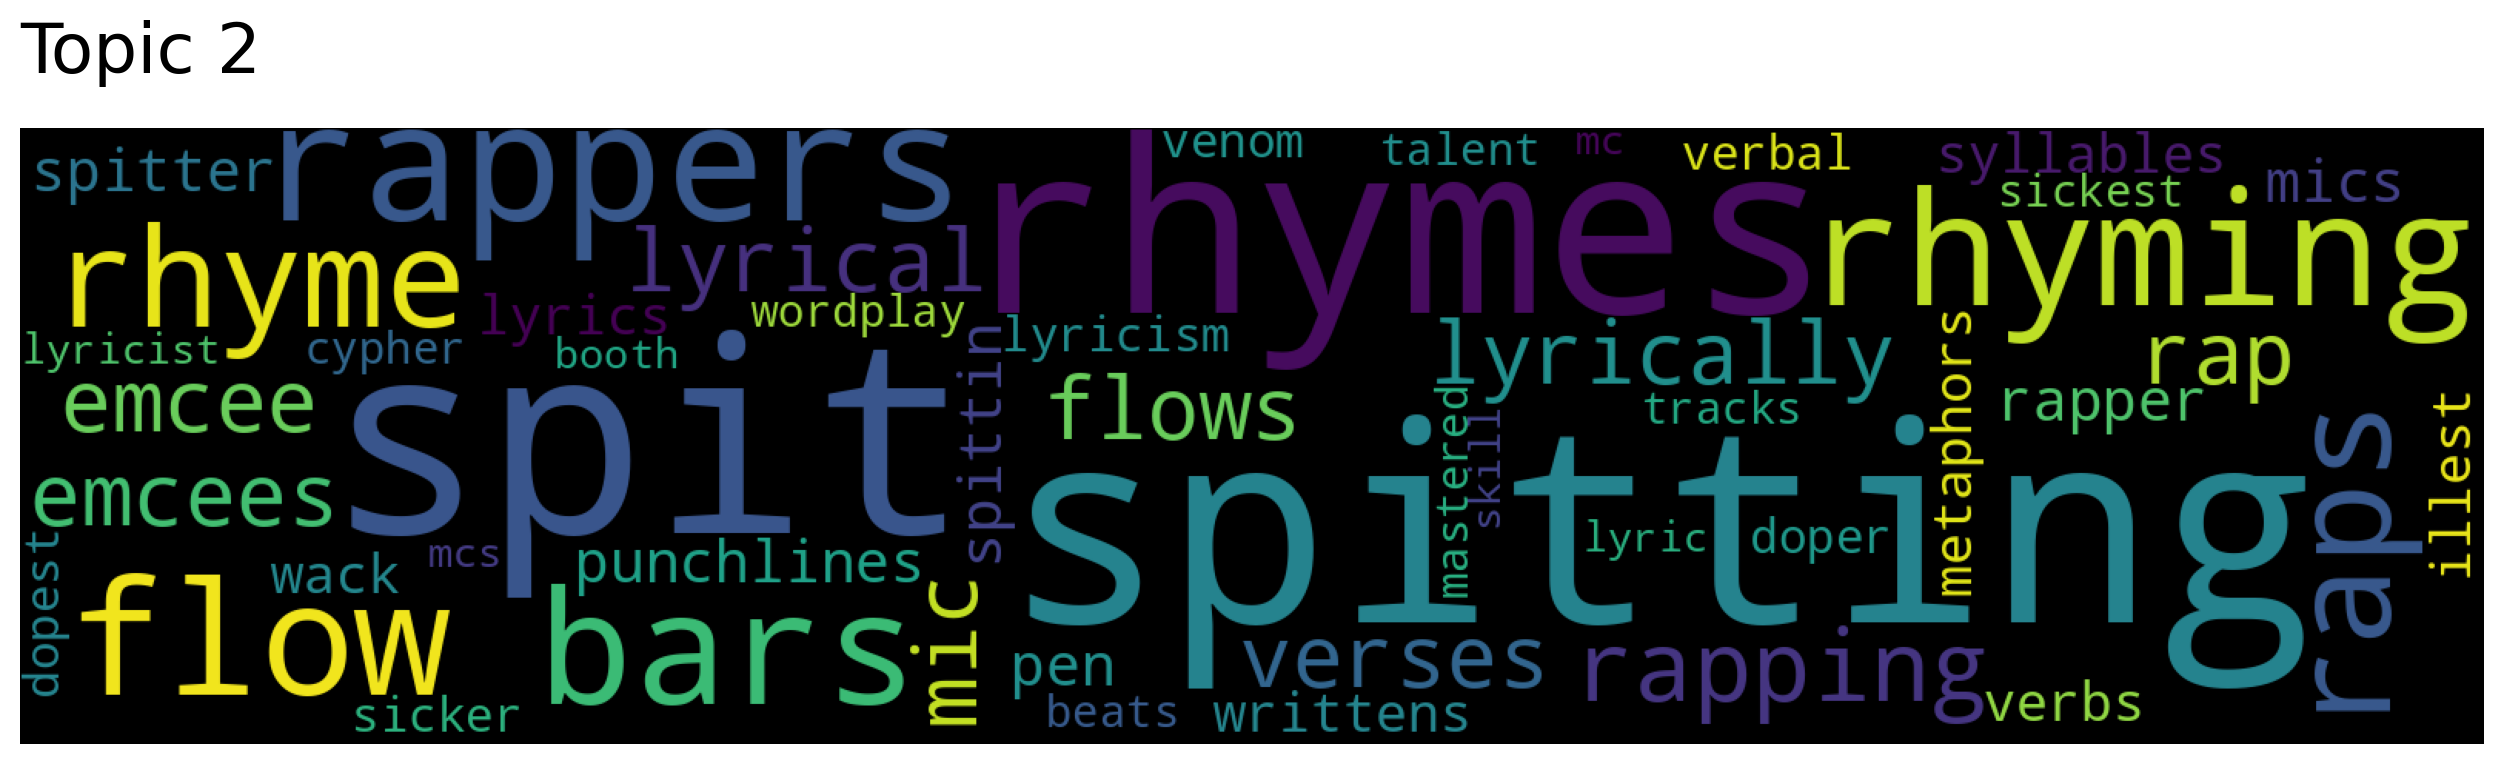

In [30]:
model.generate_topic_wordcloud(topic_nums[2])

In [31]:
documents, document_scores, document_ids = model.search_documents_by_topic(topic_num=0, num_docs=5)
for doc, score, doc_id in zip(documents, document_scores, document_ids):
    print(f"Document: {doc_id}, Score: {score}")
    print("-----------")
    print(doc)
    print("-----------")
    print()

Document: 124850, Score: 0.7590472102165222
-----------
bitches ain't shit so just give them upbitches ain't shit so just give them upbitches ain't shit so just give them upbitches ain't shit so just give them upbitches ain't shit so just give them upbitches ain't shit so just give them upbitches ain't shit so just give them upbitches ain't shit so just give them upfuck fuck fuck fuck that bitchu ain't shitsuck my dicklick and spit
-----------

Document: 68285, Score: 0.7541798949241638
-----------
keep it realain't no need for frontin'if you ain't talkin money you ain't talkin bout nothinmy jewelry look disgustin'dat ain't no discusion
-----------

Document: 161619, Score: 0.7192232012748718
-----------
i got like five bitches i don't need a thotaye post it on the block i let that 30 popaye shooters with me nigga we pack like rocknigga time is money you don't own a clockaye post it at the trap i'm with the robbersaye lil o i'm fucking nigga's daughtersnigga get it jumping like it's pa

# 2000 song lyrics topic modelling

In [33]:
df_2000_en = df[(df['year'] == 2000) & (df['language'] == 'en')]
df_2000_en.head()

title   tag                   artist  year  views  \
0          Life Floats By  rock             The Jayhawks  2000     91   
12                Glisten  rock                     Isis  2000    821   
92   Guess The Politician   pop  The Legendary Pink Dots  2000     99   
108     Spring of Freedom   pop                     RPWL  2000    126   
160                  Vega   pop             Paul Van Dyk  2000    117   

    features                                             lyrics       id  \
0         {}  [Verse 1]\nAbuse me and confuse me\nBut never,...  1325199   
12        {}  Drawn in\nKneeling, scraping, praying\n\nHer l...  1325211   
92        {}  When the fireworks start where will they be? T...  1325296   
108       {}  The kingdom was far away down by the sea\nWher...  1325316   
160       {}  There's a time for us to let go\nThere's a tim...  1325369   

    language_cld3 language_ft language  
0              en          en       en  
12             en          en       en  
92             en          en       en  
108            en          en       en  
160            en          en       en

In [34]:
# retrieve groups
total_tag_views = df_2000_en.groupby(['tag'])['views'].sum()
tag_freq = df_2000_en.groupby(['tag']).size()

# create df
df_tag = pd.DataFrame({'count' : tag_freq,'total_views' :total_tag_views})
df_tag.reset_index(inplace = True, names = 'tag')

# print the barplot
fig = px.bar(df_tag, x="tag", y="count", color='total_views')
fig.show()

In [38]:
df_2000_en.sort_values(by = 'views', ascending=False).head(10)

title      tag                             artist  \
661366  Grinch Schedule Dialogue      pop                         Jim Carrey   
283655           I Almost Let Go      pop  Kurt Carr & The Kurt Carr Singers   
32678                I’m the Map      pop                  Dora the Explorer   
66775    Dora The Explorer Theme      pop                  Dora the Explorer   
431365          I Hope You Dance  country                     Lee Ann Womack   
67875                   Superman      pop                  Five for Fighting   
423264         Backpack Backpack      pop                  Dora the Explorer   
535971            Four days late      pop             Karen Peck & New River   
497947                 Supergirl     rock                            Reamonn   
185054         Holy Are You Lord      pop                     Terry MacAlmon   

        year   views                                           features  \
661366  2000  153264                                                 {}   
283655  2000  125007                                                 {}   
32678   2000  115460                                    {"Marc Weiner"}   
66775   2000  109832  {"Harrison Chad","Marc Weiner","Kathleen Herles"}   
431365  2000   80415                                                 {}   
67875   2000   77929                                                 {}   
423264  2000   70645                                     {"Sasha Toro"}   
535971  2000   68358                                                 {}   
497947  2000   53404                                                 {}   
185054  2000   42026                                                 {}   

                                                   lyrics       id  \
661366  The nerve of those Whos!\nInviting me done the...  2209308   
283655  I almost let go\nI felt like I couldn't take l...  1625031   
32678   [MAP]\nIf there's a place you got to go\nI'm t...  1359739   
66775   Dora!\nBoots!\nCome on, Dora\n\nDo-do-do-do-Do...  1395900   
431365  [Verse 1]\nI hope you never lose your sense of...  1786575   
67875   [Verse 1]\nI can't stand to fly\nI'm not that ...  1397050   
423264  [Chorus]\nBackpack, backpack\nBackpack, backpa...  1774080   
535971  The news came that Jesus\nPlease come fast\nLa...  1976820   
497947  [Verse 1]\nYou can tell by the way she walks t...  1929581   
185054  [Verse]\nHear the sound of heaven\nLike the so...  1520882   

       language_cld3 language_ft language  
661366            en          en       en  
283655            en          en       en  
32678             en          en       en  
66775             en          en       en  
431365            en          en       en  
67875             en          en       en  
423264            en          en       en  
535971            en          en       en  
497947            en          en       en  
185054            en          en       en

In [45]:
results = df_2000_en["lyrics"].apply(clean_text)

docs = results.to_list()
docs[:2]

[" abuse me and confuse mebut never never never use meah you leave me so tiredso utterly uninspired thunder bay was a drag babythunder bay was a drag baby upon the gravel and the dustif i don't move i will rustyou're a faint recurring melodyi can't seem to recall in my mind in my souli never really loved youin my mind in my souli never really loved you ah the sun shines off the power linesand the trees they wave me onthere's a black cloud of happinessi can't finish what i've begun we hit duluth on a jag babywe hit duluth on a jag baby i grab my coat my hat and my paperbackfrom the corner of my eyes i see you smile in my mind in my souli never really loved youin my mind in my souli never really loved you i hear what they're sayingthere's no use in prayingso i'll just slip away  in my mind in my souli never really loved youin my mind in my souli never really loved you do do dodo do dodo do do do do do dodo do dodo do dodo do do do do do dodo do dodo do dodo do do do do do do ",
 "drawn i

In [50]:
model_2000 = Top2Vec(docs, speed = 'fast-learn', workers = multiprocessing.cpu_count())

2023-03-07 23:47:54,597 - top2vec - INFO - Pre-processing documents for training
2023-03-07 23:47:59,253 - top2vec - INFO - Creating joint document/word embedding
2023-03-07 23:49:31,142 - top2vec - INFO - Creating lower dimension embedding of documents
2023-03-07 23:49:42,702 - top2vec - INFO - Finding dense areas of documents
2023-03-07 23:49:43,302 - top2vec - INFO - Finding topics


In [51]:
today = datetime.now().strftime("%d%m%Y")

path = "models/" + "top2vec_2000_" + today

model_2000.save(path)
model_2000 = Top2Vec.load(path)

In [52]:
model_2000.get_num_topics()

4

In [54]:
topic_words, word_scores, topic_nums = model_2000.get_topics(4)
topic_words[0]

array(['jamie', 'thomas', 'ly', 'loo', 'in', 'of', 'to', 'the', 'you',
       'that', 'and', 'my', 'junt', 'be', 'for', 'as', 'it', 'just',
       'time', 'is', 've', 'll', 'can', 'blah', 'emerge', 'not', 'our',
       'never', 'eyes', 'me', 'on', 'have', 'this', 'woof', 'could',
       'they', 'through', 'but', 'was', 'your', 'all', 'there', 'know',
       'are', 'were', 'has', 'with', 'take', 'see', 'death'], dtype='<U9')

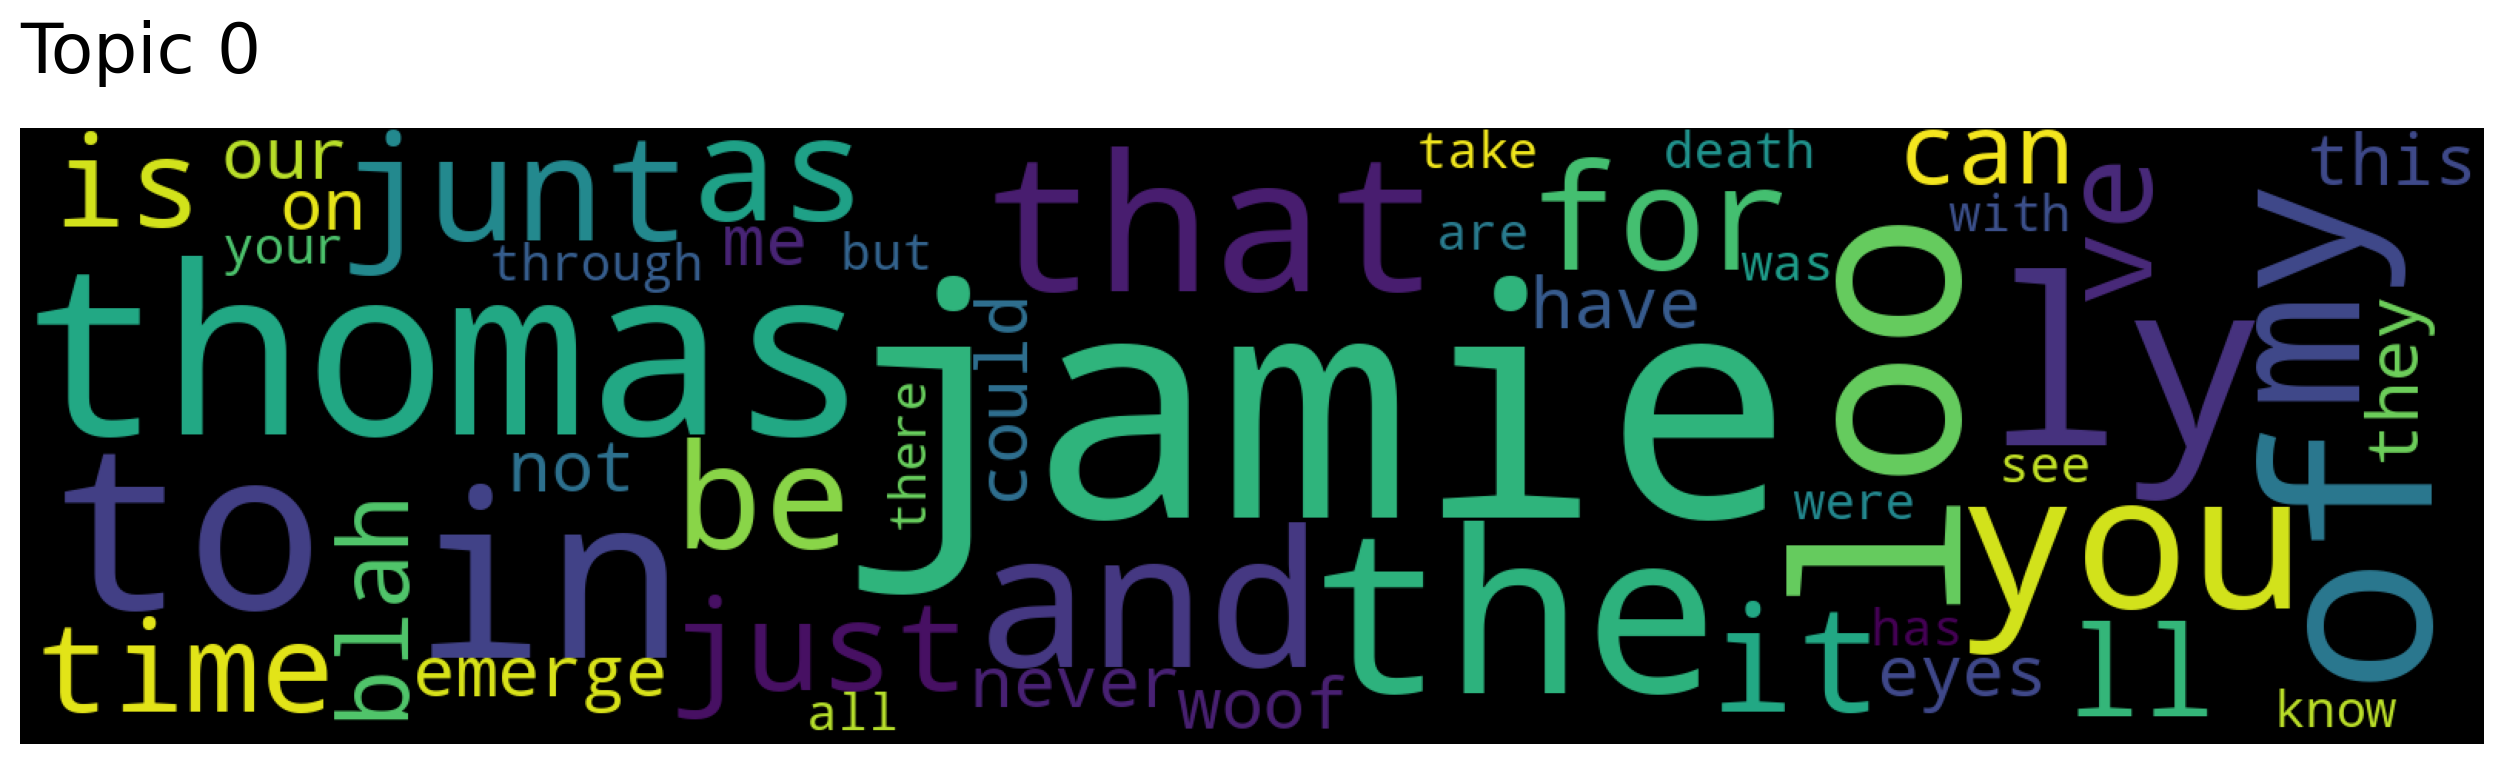

In [55]:
model_2000.generate_topic_wordcloud(topic_nums[0])

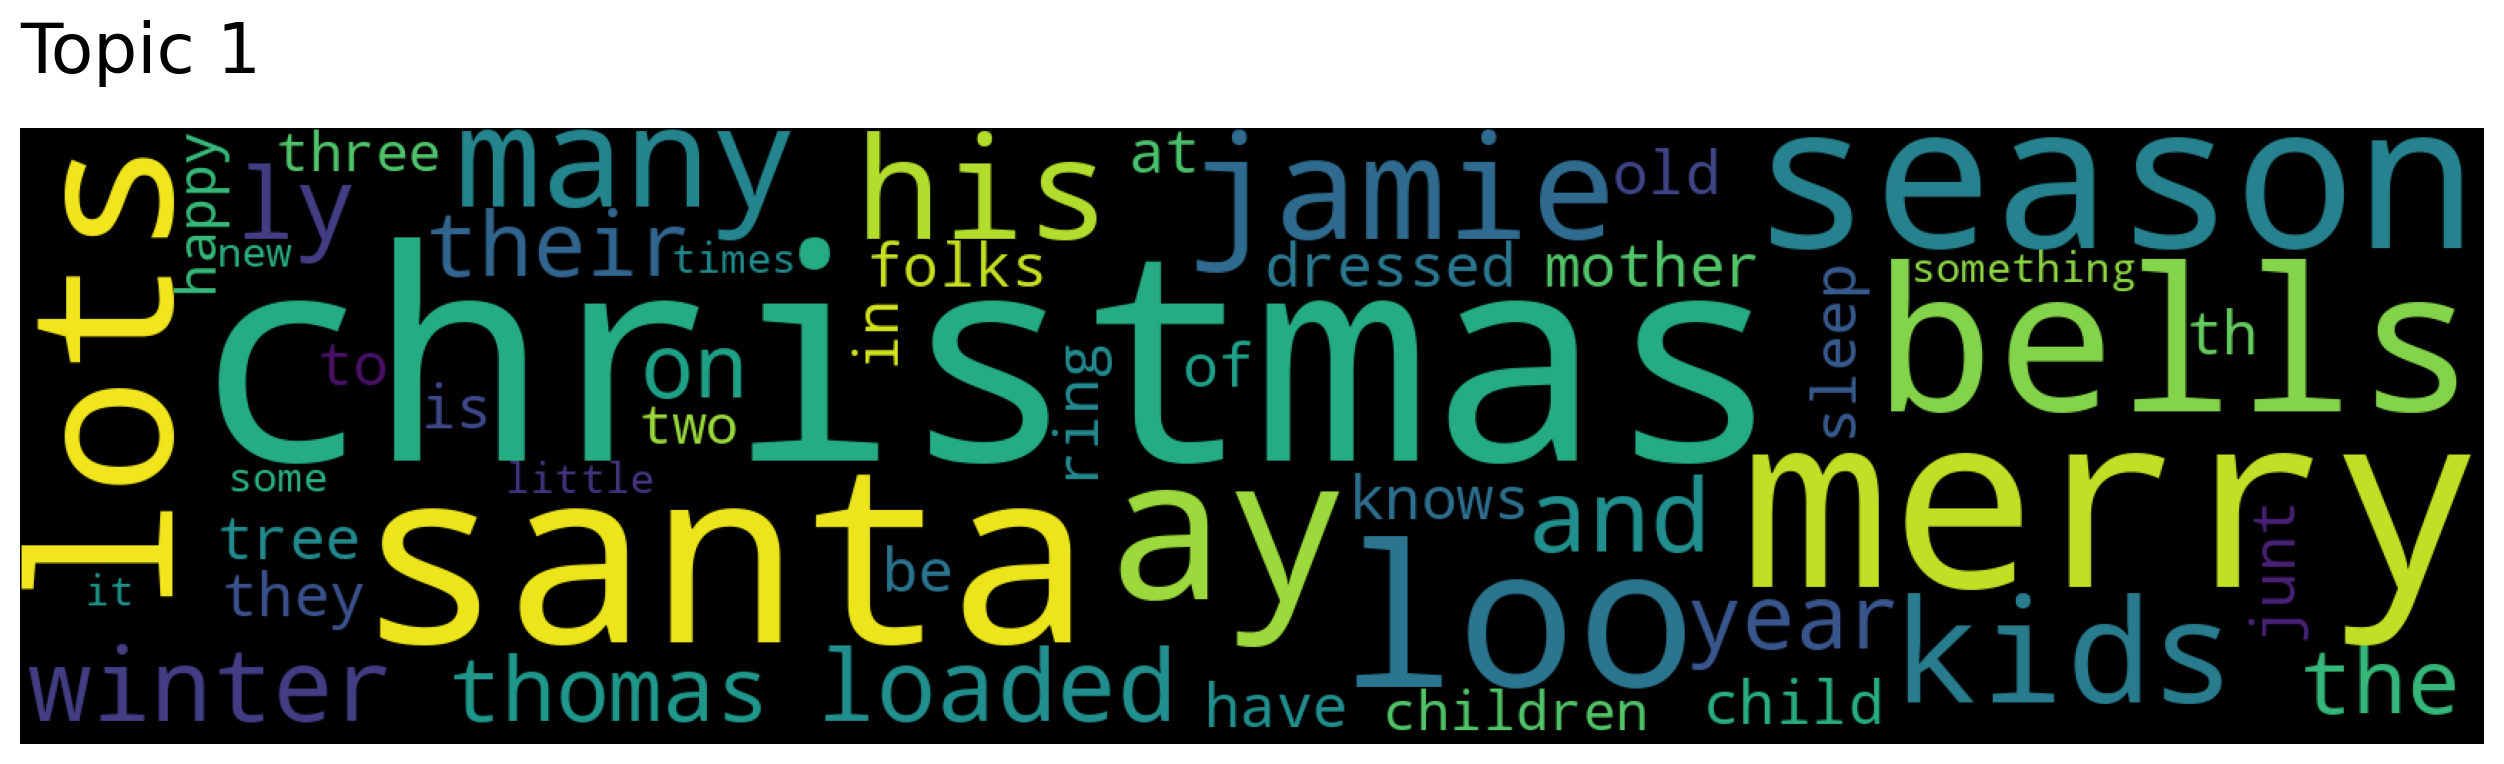

In [56]:
model_2000.generate_topic_wordcloud(topic_nums[1])

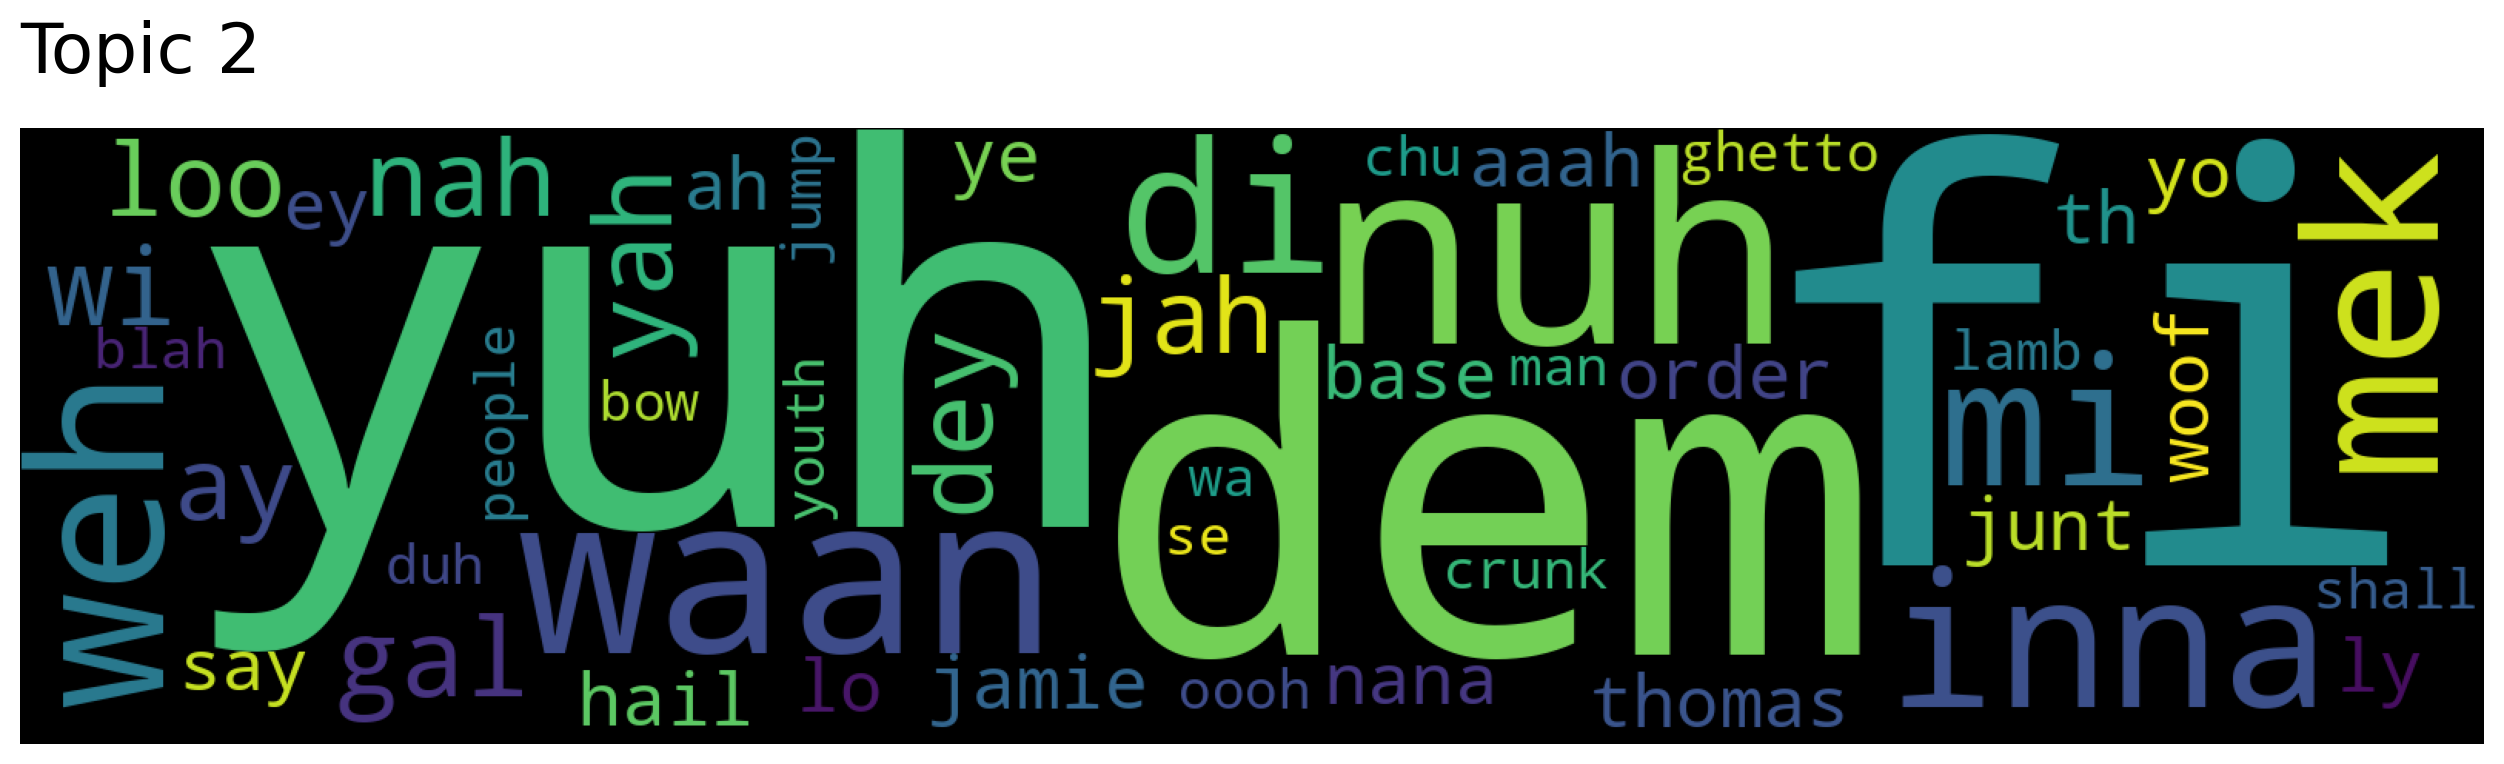

In [57]:
model_2000.generate_topic_wordcloud(topic_nums[2])

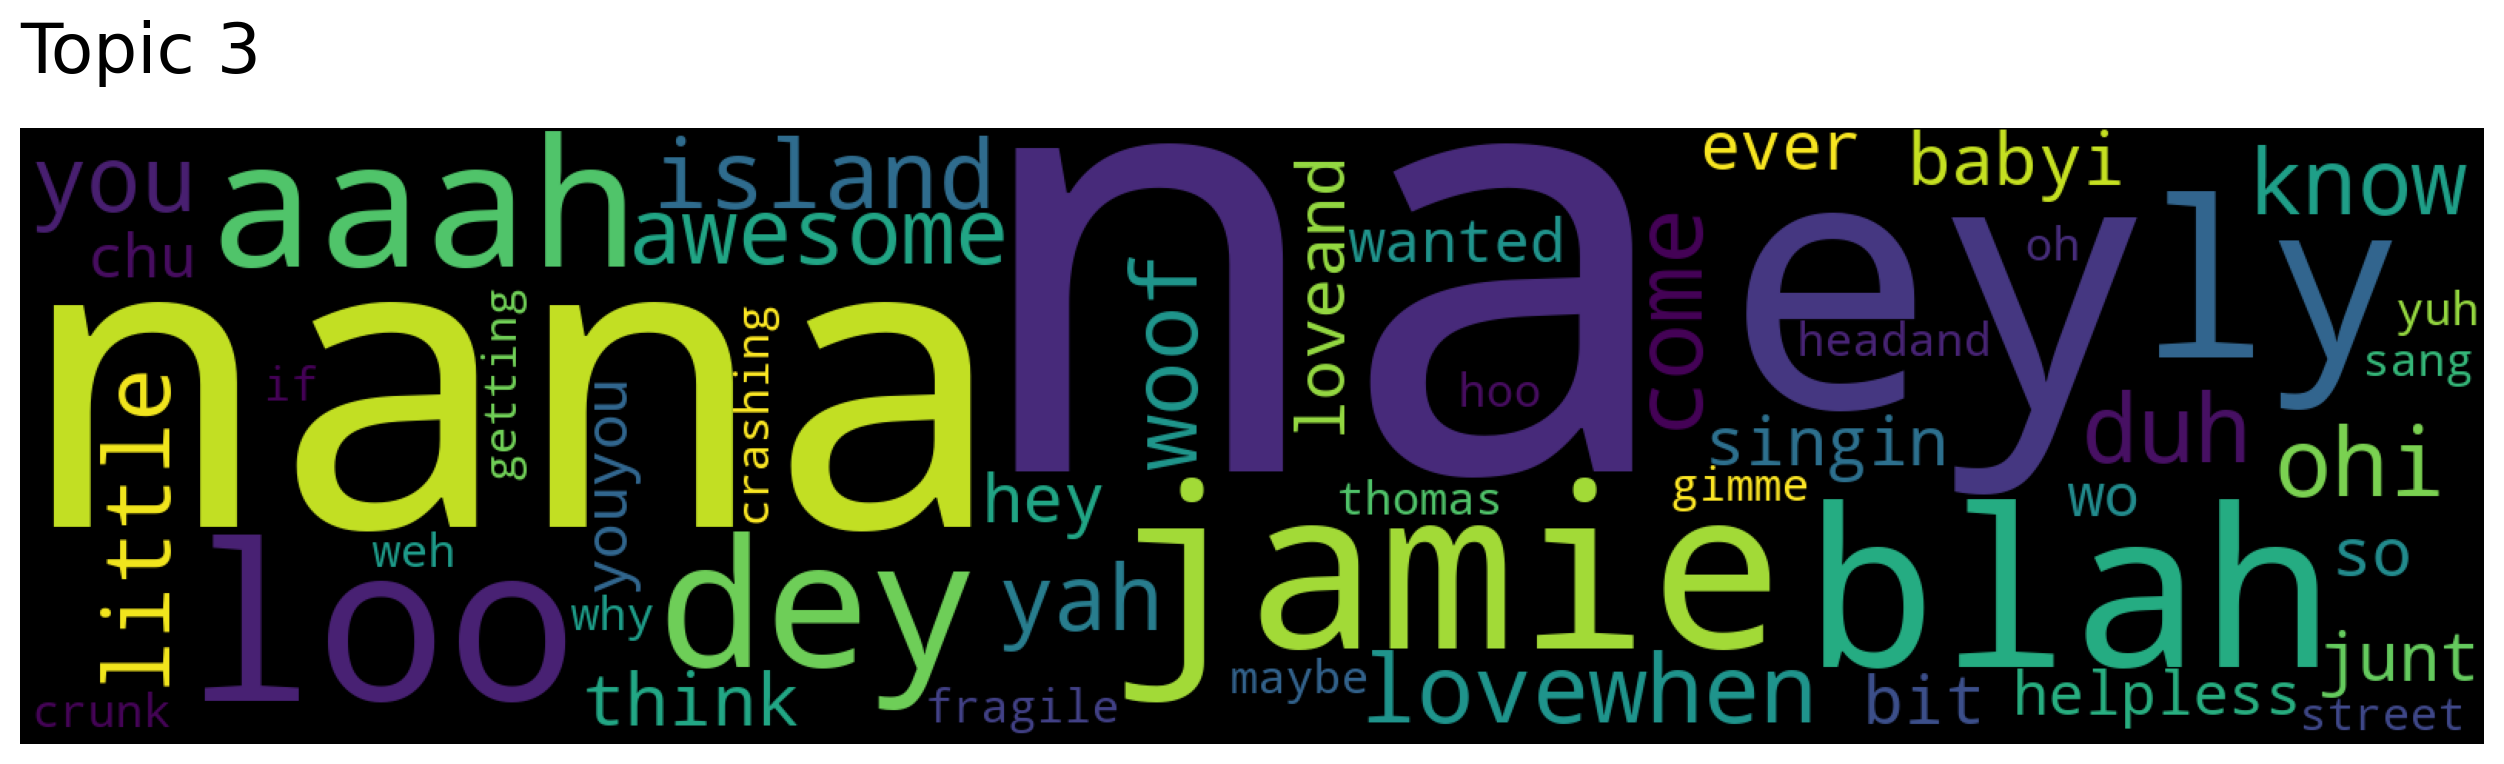

In [58]:
model_2000.generate_topic_wordcloud(topic_nums[3])